In [23]:
import numpy as np
from ptsa.data.readers import EEGReader,TalReader
from ptsa.data.filters import MorletWaveletFilterCpp,MonopolarToBipolarMapper, MorletWaveletFilter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from ptsa.data.TimeSeriesX import TimeSeriesX
import pandas as pd
from scipy.stats import zscore,ttest_rel
%matplotlib inline 
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score,roc_curve
from cluster_helper import cluster
from sklearn.externals import joblib
import xarray
from scipy import interp
import pprint


In [24]:
def get_vault(remaining, vault):
    remainingZ = (remaining - remaining.mean('events'))/remaining.std('events')
    vaultZ = (vault - vault.mean('events'))/vault.std('events')
    #logistic regression
    lr = LogisticRegression(penalty='l2', C=1.0)
    lrFit = lr.fit(remainingZ, remainingZ.events.values['recalled'])
    vault_predictions = lrFit.predict_proba(vaultZ)[:, 1]
    vault_actuals = vaultZ.events.values['recalled']
    return [vault_predictions, vault_actuals]

In [25]:
#takes in number of session to leave out
def loso(numS, features):
    
    #regular = sessions not left out
    regular = features.sel(events=features.events.values['session'] != numS)
    regularZ = (regular-regular.mean('events'))/regular.std('events')
    
    #session left out
    left_out = features.sel(events=features.events.values['session']==numS)
    left_outZ = (left_out - left_out.mean('events'))/left_out.std('events')
    
    
    #logistic regression
    lr = LogisticRegression(penalty='l2', C=1.0)
    lrFit = lr.fit(regularZ, regularZ.events.values['recalled'])
    test_probs = lrFit.predict_proba(left_outZ)[:, 1]
    actual_labels = left_outZ.events.values['recalled']
    return [test_probs, actual_labels]

In [29]:
def get_probs_actual_loso(feat_array):
    
    probs = np.empty(len(feat_array))
    probs.fill(np.nan)
    actual = np.empty(len(feat_array))
    actual.fill(np.nan)

    for ss in np.unique(feat_array.events.values['session']):
        print(str(ss) + "/" + str(len(np.unique(feat_array.events.values['session']))))
        loso_result = loso(ss,feat_array)
        probs[feat_array.events.values['session']==ss] = loso_result[0]
        actual[feat_array.events.values['session']==ss] = loso_result[1]
    return [probs,actual]


In [27]:
#ROC curve depicts True Positive Rate (on the y-axis) versus the False Positive Rate (on the x-axis)
#classifer_ps: array of classifier output probabilities
#values: array of values that correspond to their true labels
#labels: array of true labels for the above values
#posLabel: label for the positive class
#returns ROC curve [xs, ys]
def getROC(classifier_ps, labels, values, posLabel):
    xs = [0] * len(classifier_ps)
    ys = xs[:]
    
    #use each probability as a decision threshold (< is neg, >= is pos)
    numPos = sum((labels[i] == posLabel) for i in range(0, len(values)))
    numNeg = sum((labels[i] != posLabel) for i in range(0, len(values)))
    count = 0
    for threshold in classifier_ps:
        falsePosCount = sum((values[i] >= threshold and labels[i] != posLabel) for i in range(0, len(values)))
        truePosCount = sum((values[i] >= threshold and labels[i] == posLabel) for i in range(0, len(values)))

        fpr = (1.0 * falsePosCount) / numNeg
        tpr = (1.0 * truePosCount) / numPos
        xs[count] = fpr
        ys[count] = tpr
        count += 1
    
    return [np.array(xs), np.array(ys)]
        

def getAUC(rocX, rocY):
    return np.trapz(rocY, rocX)

def plotROCAvg(title, base_fpr, tprs_lolo, tprs_loso, filename=None): 
    avg_tprs_lolo = np.mean(tprs_lolo, axis=0)
    ste_tprs_lolo = np.std(tprs_lolo,axis=0) / np.sqrt(np.shape(tprs_lolo)[0])
    lolo_lower = avg_tprs_lolo - ste_tprs_lolo
    lolo_upper = np.minimum(avg_tprs_lolo + ste_tprs_lolo,1)
    
    
    avg_tprs_loso = np.mean(tprs_loso, axis=0)
    ste_tprs_loso = np.std(tprs_loso,axis=0) / np.sqrt(np.shape(tprs_loso)[0])
    loso_lower = avg_tprs_loso - ste_tprs_loso
    loso_upper = np.minimum(avg_tprs_loso + ste_tprs_loso,1)
    
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    plt.title(title)
    
    all_tprs = {'LOLO': {'tpr': avg_tprs_lolo, 'color': 'blue'}, 'LOSO': {'tpr': avg_tprs_loso, 'color': 'orange'}}
    for label in ['LOLO', 'LOSO']:
        ax.plot(base_fpr, all_tprs[label]['tpr'], 
                label='%s; AUC=%.3f' % (label, getAUC(base_fpr, all_tprs[label]['tpr'])),
               color=all_tprs[label]['color'])
    
    
    plt.fill_between(base_fpr, lolo_lower, lolo_upper, color= all_tprs['LOLO']['color'], alpha = 0.3)
    
    plt.fill_between(base_fpr, loso_lower, loso_upper, color= all_tprs['LOSO']['color'], alpha = 0.3)

    
    ax.legend(loc='best')
    ax.plot([0,1], [0, 1], 'k--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

    if filename:
        plt.savefig("%s.jpg" % (filename), bbox_inches='tight')

    plt.show()
    

def plotROC(title, labelParam, labels, ROCXs, ROCYs, filename=None):
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    plt.title(title)
    i = 0
    for label in labels:
        ax.plot(ROCXs[i], ROCYs[i], label='%s%s%s; AUC=%.3f' % (labelParam if labelParam else '', 
                                                                '=' if labelParam else '' ,
                                                                labels[i], getAUC(ROCXs[i], ROCYs[i])))
        i+=1
    ax.legend(loc='best', title=labelParam)
    ax.plot([0,1], [0, 1], 'k--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    #fig.subplots_adjust(0.18,0.16, 0.98, 0.99, 0.1, 0.1)

    if filename:
        plt.savefig("%s.jpg" % (filename), bbox_inches='tight')

    plt.show()

# Save from HDF to NP DATA for EEG Subjects

In [ ]:
def saveData(subs):
    for subjectID in subs[0]:
    print(subjectID)
    #ADD PATH TO HDF FILE CONTAINING POWER DATA
    #data = TimeSeriesX.from_hdf('/data/home/jonlevi/ML_Project/iEEG_Power_Files/%s.hdf5' % (subjectID))
    
    features = np.log10(data.stack(features=('frequency','channels')))
    
    lastSession = np.max(np.unique(features.events.values['session']))
    vault = features.sel(events=features.events.values['session']==lastSession)
    remaining = features.sel(events=features.events.values['session']!=lastSession)
    print("Getting Regular Sessions Cross-Validation...")
    data_remaining = get_probs_actual_loso(remaining)
    print("Getting Vault Session Tets...")
    data_vault = get_vault(remaining,vault)
    print("Saving To Disk...")
    #ADD PATH FOR TARGET TO NP.SAVE
    path = ''
    np.save(path, [data_remaining, data_vault])

R
Now doing the vault
Got the vault
1
Now doing the vault
Got the vault
0
Now doing the vault
Got the vault
5
Now doing the vault
Got the vault
1
Now doing the vault
Got the vault
J
Now doing the vault
Got the vault


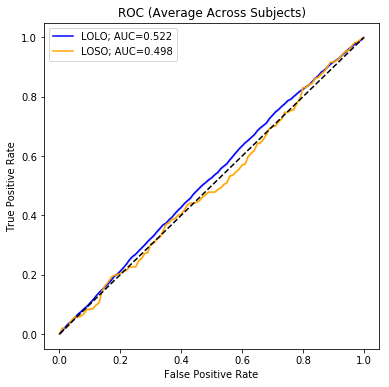

{'0': '0.521', '1': '0.521', '5': '0.521', 'J': '0.521', 'R': '0.521'}
{'0': '0.498', '1': '0.498', '5': '0.498', 'J': '0.498', 'R': '0.498'}


In [39]:
subs=  ['R1051J', 'R1060M', 'R1065J', 'R1137E', 'R1154D', 'R1161E','R1189M', 'R1195E', 'R1236J']

# subs=  ['LTP123', 'LTP133', 'LTP249', 'LTP258', 'LTP330', 'LTP115', 'LTP138', 'LTP265', 'LTP283',
# 'LTP93', 'LTP259', 'LTP285', 'LTP304']



tprs_lolo = []
tprs_loso = []
base_fpr = np.linspace(0, 1, 101)

aucs_loso = {}
aucs_vault = {}


for subjectID in subs[0]:
    print(subjectID)
    #data = TimeSeriesX.from_hdf('/data/home/jonlevi/ML_Project/iEEG_Power_Files/%s.hdf5' % (subjectID))
    data = TimeSeriesX.from_hdf('/data/home/jonlevi/ML_Project/LTP123.hdf5')
    
    features = np.log10(data.stack(features=('frequency','channels')))
    
    lastSession = np.max(np.unique(features.events.values['session']))
    vault = features.sel(events=features.events.values['session']==lastSession)
    remaining = features.sel(events=features.events.values['session']!=lastSession)
    
    data_remaining = get_probs_actual_loso(remaining)
    probs_remaining = data_remaining[0]
    actual_remaining = data_remaining[1]
    
    print("Now doing the vault")
    data_vault = get_vault(remaining,vault)
    probs_vault = data_vault[0]
    actual_vault = data_vault[1]
    
    print("Got the vault")
    
    fprs,tprs,thresholds = roc_curve(actual_remaining, probs_remaining)
    #myROC_LOSO = getROC(thresholds,actual_remaining,probs_remaining,1)
#     fprs = myROC_LOSO[0]
#     tprs = myROC_LOSO[1]
    aucs_loso[subjectID] = format(getAUC(fprs,tprs),'.3f')
    tpr_lolo = interp(base_fpr, fprs, tprs)
    tpr_lolo[0] = 0.0
    tprs_lolo.append(tpr_lolo)
    

    fprs2,tprs2,thresholds = roc_curve(actual_vault, probs_vault)
#     myROC_LOSO = getROC(thresholds,actual_vault,probs_vault,1)
#     fprs2 = myROC_LOSO[0]
#     tprs2 = myROC_LOSO[1]
    aucs_vault[subjectID] = format(getAUC(fprs2,tprs2),'.3f')
    tpr_loso = interp(base_fpr, fprs2, tprs2)
    tpr_loso[0] = 0.0
    tprs_loso.append(tpr_loso)

plotROCAvg("ROC (Average Across Subjects)",base_fpr, tprs_lolo, tprs_loso,
      None)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(aucs_loso)
pp.pprint(aucs_vault)

# Part 3

(576,)

In [40]:
np.save('/data/home/jonlevi/ML_Project/scalp_data_files/LTP123', [data_remaining, data_vault])